In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import umap
import torch
import plotly.graph_objects as go
from persim import plot_diagrams
import pandas as pd
from circular_cords import get_coords
from fix_umap_bug import fix_umap_bug

fix_umap_bug()

Import the data. "activity" is then a 50000xneurons matrix with all activations.

In [2]:
layer = "inception3a"
activity = np.load(f"activations/ILSVRC2015/{layer}.npy")
print(activity.shape)
neurons = activity.shape[1]

(50761, 256)


In [4]:
cluster_info = pd.read_pickle(f"data/clusters/{layer}.pkl")
print(cluster_info.head())

    cluster_id  cluster_size  \
8            8           516   
22          22           422   
26          26           753   
13          13          3920   
20          20          1024   

                                      cluster_members  longest_bar  \
8   [0, 118, 172, 351, 412, 634, 856, 864, 973, 10...     0.843400   
22  [31, 87, 211, 225, 723, 1023, 1093, 1177, 1279...     0.602427   
26  [148, 161, 185, 230, 341, 414, 500, 554, 674, ...     0.594780   
13  [1, 2, 5, 21, 39, 51, 63, 75, 77, 86, 88, 105,...     0.588146   
20  [18, 37, 95, 97, 134, 155, 223, 268, 313, 413,...     0.568071   

                                  Top 10 longest bars  
8   [0.2015455961227417, 0.20216837525367737, 0.21...  
22  [0.09971773624420166, 0.10118222236633301, 0.1...  
26  [0.24518758058547974, 0.2676054537296295, 0.27...  
13  [0.30871912837028503, 0.3087816536426544, 0.32...  
20  [0.2454257607460022, 0.28167542815208435, 0.28...  


In [12]:
cluster_info

,cluster_id,cluster_size,cluster_members,longest_bar,Top 10 longest bars
8,8,516,"[0, 118, 172, 351, 412, 634, 856, 864, 973, 10...",0.843400,"[0.2015455961227417, 0.20216837525367737, 0.21..."
22,22,422,"[31, 87, 211, 225, 723, 1023, 1093, 1177, 1279...",0.602427,"[0.09971773624420166, 0.10118222236633301, 0.1..."
26,26,753,"[148, 161, 185, 230, 341, 414, 500, 554, 674, ...",0.594780,"[0.24518758058547974, 0.2676054537296295, 0.27..."
13,13,3920,"[1, 2, 5, 21, 39, 51, 63, 75, 77, 86, 88, 105,...",0.588146,"[0.30871912837028503, 0.3087816536426544, 0.32..."
20,20,1024,"[18, 37, 95, 97, 134, 155, 223, 268, 313, 413,...",0.568071,"[0.2454257607460022, 0.28167542815208435, 0.28..."
2,2,567,"[115, 145, 195, 231, 249, 297, 320, 330, 378, ...",0.560853,"[0.24776822328567505, 0.2500531077384949, 0.25..."
29,30,287,"[56, 484, 596, 678, 727, 1004, 1100, 1266, 131...",0.559914,"[0.22296637296676636, 0.23686718940734863, 0.2..."
21,21,392,"[243, 477, 511, 536, 761, 1073, 1413, 1458, 16...",0.558542,"[0.29596614837646484, 0.3142196536064148, 0.34..."
1,1,1309,"[72, 139, 141, 207, 238, 290, 347, 361, 381, 4...",0.544262,"[0.27991729974746704, 0.28648579120635986, 0.2..."
5,5,764,"[14, 30, 71, 163, 173, 220, 365, 466, 613, 649...",0.539209,"[0.22778451442718506, 0.24499833583831787, 0.2..."


In [44]:
cluster_num = 8
cluster = activity[cluster_info["cluster_members"][cluster_num]]
print(cluster.shape)

(516, 256)


In [45]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))

In [46]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

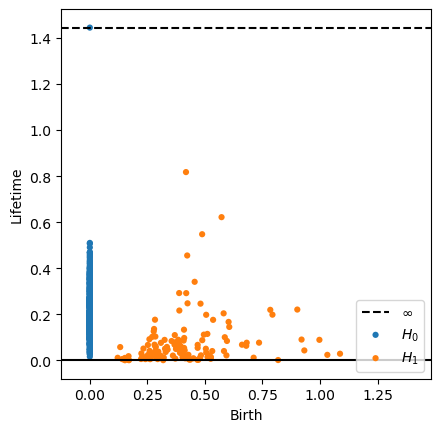

In [47]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

In [361]:
f = cluster_info["circle_param"][cluster_num]

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [48]:
layout_3d = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

In [50]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("testing_clusters.html")
fig.show()

In [355]:
layout_2d = umap.UMAP(
    n_components=2, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

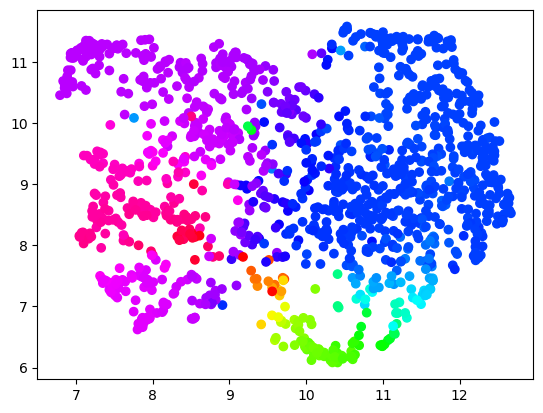

In [356]:
plt.scatter(x=layout_2d[:, 0], y=layout_2d[:, 1], c=f, cmap="hsv")

In [49]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

circle_num = 1

threshold = births1[iMax[-circle_num]] + (
    deaths1[iMax[-circle_num]] - births1[iMax[-circle_num]]
) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-circle_num]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

number of vertices = 516
number of edges = 14677


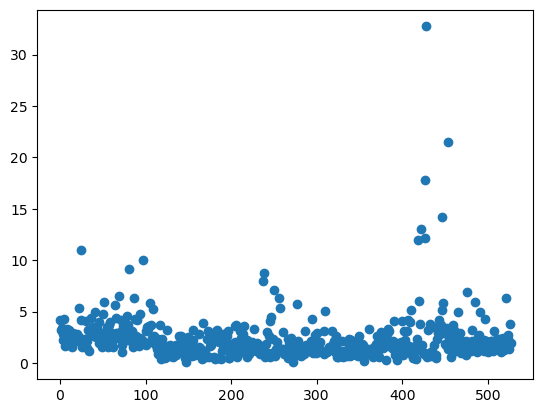

In [14]:
inform_rates = cluster_info["info_per_node"][cluster_num]
plt.scatter(range(neurons), inform_rates)
plt.show()

Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

In [24]:
inform = 10
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[ 25  97 418 422 426 427 428 446 454]


9

Lets compute everything again but just with these neurons:

In [25]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=False, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

In [26]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("testing_clusters.html")
fig.show()

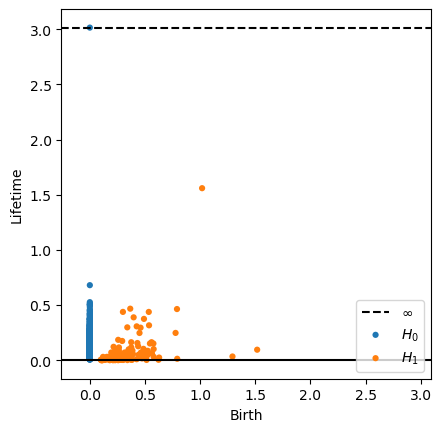

In [27]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=False,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True, lifetime=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [36]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 925
number of edges = 122621


In [37]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
fig.write_html("circular_feature_3D_final_v2_copy.html")
fig.show()

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [38]:
buckets = 10
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,), (9,)]
[8, 13, 27, 48, 73, 281, 391, 523, 424, 60]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████████████████| 512/512 [01:02<00:00,  8.14it/s]



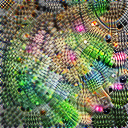

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.71it/s]



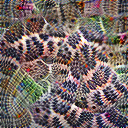

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:09<00:00,  7.33it/s]



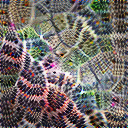

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:06<00:00,  7.65it/s]



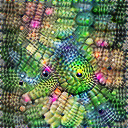

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:04<00:00,  7.99it/s]



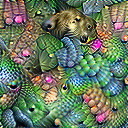

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.43it/s]



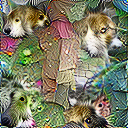

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:08<00:00,  7.51it/s]



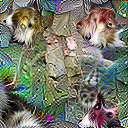

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:10<00:00,  7.29it/s]



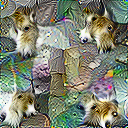

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:10<00:00,  7.26it/s]



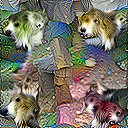

100%|█████████████████████████████████████████████████████████████████| 512/512 [01:07<00:00,  7.58it/s]



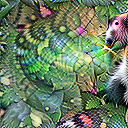

In [39]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

In [52]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_5/25/im_{i}.npy", im[0][0])

In [46]:
from PIL import Image

a = np.load("data/circle_pics/circle_3/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()